# Neural Networks For Market Trading

In [47]:
import pandas as pd
df = pd.read_csv("c:/Users/aliho/Downloads/Iran.Khodro.csv")
#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

,year,month,day,open,high,low,close,value,volume,openint,per,open.1,last
4620,2001,3,31,2840,2848,2800,2838,500068371.0,177362,161,D,2849,2838
4621,2001,3,28,2800,2849,2796,2849,227566666.0,80676,104,D,2795,2849
4622,2001,3,27,2795,2800,2795,2795,466405131.0,166600,120,D,2798,2795
4623,2001,3,26,2801,2810,2797,2798,270595190.0,96613,98,D,2800,2798
4624,2001,3,25,2798,2802,2798,2800,310368080.0,110870,115,D,2798,2800


# Support and Resistance FUNCTIONS

In [48]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1

In [49]:
length = len(df)
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
open = list(df['open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.high[l]-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c2 = abs(max(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c3 = min(df.open[l],df.close[l])<min(levels, key=lambda x:abs(x-df.high[l]))
    c4 = df.low[l]<min(levels, key=lambda x:abs(x-df.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.low[l]-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c2 = abs(min(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c3 = max(df.open[l],df.close[l])>min(levels, key=lambda x:abs(x-df.low[l]))
    c4 = df.high[l]>min(levels, key=lambda x:abs(x-df.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [50]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [51]:
df['signal']=signal

In [52]:
df[df['signal']==1].count()

year       46
month      46
day        46
open       46
high       46
low        46
close      46
value      46
volume     46
openint    46
per        46
open.1     46
last       46
signal     46
dtype: int64

In [53]:
df.columns = ['year', 'month', 'day', 'Open', 'High', 'Low', 'Close', 'Value',
       'volume', 'openint', 'per', 'open.1', 'last', 'signal']
#df=df.iloc[100:200]
df

,year,month,day,Open,High,Low,Close,Value,volume,openint,per,open.1,last,signal
0,2023,5,15,3840,3840,3650,3722,1.770000e+12,476266894,14330,D,3739,3700,0
1,2023,5,14,3651,3833,3616,3739,2.740000e+12,732652251,22810,D,3651,3830,0
2,2023,5,13,3703,3740,3643,3651,2.930000e+12,801623282,19931,D,3834,3644,0
3,2023,5,10,4052,4071,3782,3834,3.140000e+12,820010030,19934,D,3981,3782,0
4,2023,5,9,3928,4128,3923,3981,7.190000e+12,1806190970,45225,D,4129,4041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4620,2001,3,31,2840,2848,2800,2838,5.000684e+08,177362,161,D,2849,2838,0
4621,2001,3,28,2800,2849,2796,2849,2.275667e+08,80676,104,D,2795,2849,0
4622,2001,3,27,2795,2800,2795,2795,4.664051e+08,166600,120,D,2798,2795,0
4623,2001,3,26,2801,2810,2797,2798,2.705952e+08,96613,98,D,2800,2798,0


In [54]:
def SIGNAL():
    return df.signal

In [77]:
import pandas as pd

# Assuming df is your DataFrame
# Specify the path where you want to save the CSV file
file_path = 'C:/Users/YourUsername/Documents/output.csv'  # Update this path

# Export the DataFrame to a CSV file
df.to_csv(file_path, index=False)


OSError: Cannot save file into a non-existent directory: 'C:\Users\YourUsername\Documents'

In [55]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, 
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), 
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True). 
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin 
#with more fine-grained (e.g. hourly) data.

In [56]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 600e-4
            tp1 = self.data.Close[-1] + 450e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 600e-4
            tp1 = self.data.Close[-1] - 450e-4
            self.sell(sl=sl1, tp=tp1)

In [57]:
from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
stat



C:\Users\aliho\AppData\Local\Temp\ipykernel_28864\1132592598.py:3: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
C:\Users\aliho\AppData\Local\Temp\ipykernel_28864\1132592598.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                     0.0
End                                    4624.0
Duration                               4624.0
Exposure Time [%]                    2.054054
Equity Final [$]                      5967.18
Equity Peak [$]                       10000.0
Return [%]                           -40.3282
Buy & Hold Return [%]              -24.771628
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -40.3282
Avg. Drawdown [%]                    -40.3282
Max. Drawdown Duration                 4211.0
Avg. Drawdown Duration                 4211.0
# Trades                                 95.0
Win Rate [%]                              0.0
Best Trade [%]                           -0.0
Worst Trade [%]                     -4.945298
Avg. Trade [%]                    

In [58]:
print(df.columns)


Index(['year', 'month', 'day', 'Open', 'High', 'Low', 'Close', 'Value',
       'volume', 'openint', 'per', 'open.1', 'last', 'signal'],
      dtype='object')


In [73]:
bt.plot()

GridPlot(id='p1615', ...)

In [60]:
#Target flexible way
pipdiff = 250*1e-4 #for TP
SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<Axes: >

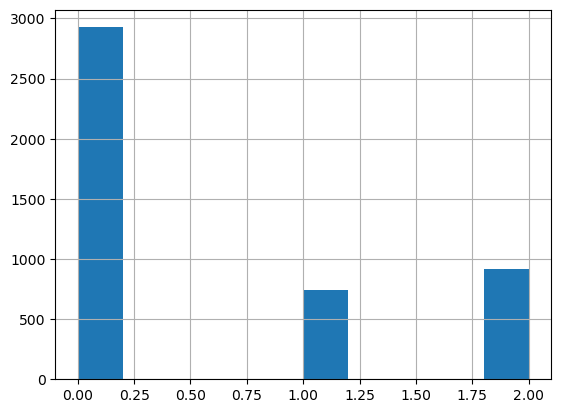

In [61]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(30, df)
#df.tail(20)
#df['Target'] = df['Target'].astype(int)
df['Target'].hist()

In [64]:
import pandas_ta as pa
df["RSI"] = pa.rsi(df.Close, length=16)
df.tail(20)

,year,month,day,Open,High,Low,Close,Value,volume,openint,per,open.1,last,signal,Target,RSI
4605,2001,4,24,3089,3130,3089,3130,2.196484e+09,705864,419,D,3090,3130,0,NaN,29.459381
4606,2001,4,23,3086,3098,3085,3090,1.529795e+09,495008,410,D,3084,3090,0,NaN,28.066000
4607,2001,4,22,3091,3100,3050,3084,3.112180e+09,1014348,383,D,3087,3084,0,NaN,27.855199
4608,2001,4,21,3079,3101,3078,3087,6.598015e+09,2129585,331,D,3079,3087,1,NaN,28.143045
4609,2001,4,18,3079,3100,3072,3079,1.650557e+09,534555,387,D,3077,3079,0,NaN,27.827238
4610,2001,4,17,3068,3100,3065,3077,1.187554e+09,386136,311,D,3068,3077,0,NaN,27.744216
4611,2001,4,16,3058,3068,3029,3068,8.161171e+08,268061,325,D,3059,3068,2,NaN,27.352510
4612,2001,4,15,3093,3095,3050,3059,7.072407e+08,229777,261,D,3092,3059,0,NaN,26.946700
4613,2001,4,14,3084,3110,3080,3092,1.343732e+09,434057,398,D,3080,3092,0,NaN,30.953232
4614,2001,4,11,3082,3100,3071,3080,1.865311e+09,604953,458,D,3080,3080,0,NaN,30.308485


In [65]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

              year        month          day          Open          High  \
count  4577.000000  4577.000000  4577.000000   4577.000000   4577.000000   
mean   2011.977059     3.976185    42.703955   3079.967227   3129.102687   
std       6.432690     2.881564    62.396579   1736.987037   1770.609603   
min    2001.000000     1.000000     1.000000    860.000000    870.000000   
25%    2006.000000     1.000000    10.000000   2036.000000   2075.000000   
50%    2012.000000     3.000000    19.000000   2710.000000   2759.000000   
75%    2018.000000     6.000000    28.000000   3349.000000   3400.000000   
max    2023.000000     9.000000   231.000000  13037.000000  13450.000000   

                Low         Close         Value        volume        openint  \
count   4577.000000   4577.000000  4.577000e+03  4.577000e+03    4577.000000   
mean    3029.407035   3082.603015  3.064025e+11  1.015572e+08    3986.916102   
std     1692.634376   1731.115060  1.068028e+12  3.136124e+08   11772.54744

In [66]:
attributes = ['RSI', 'signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,RSI,Target,signalcategory_0,signalcategory_1,signalcategory_2
0,62.500000,0.0,True,False,False
1,63.120624,0.0,True,False,False
2,56.761591,0.0,True,False,False
3,56.212445,0.0,True,False,False
4,55.411886,0.0,True,False,False
...,...,...,...,...,...
4572,46.587774,0.0,True,False,False
4573,50.377461,0.0,True,False,False
4574,51.403836,1.0,True,False,False
4575,51.670404,0.0,True,False,False


In [68]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 65.2513%
****Test Results****
Accuracy: 61.2809%


In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[1950    8   59]
 [ 471   14   38]
 [ 533    4  126]]
[[808  19  71]
 [207   2  11]
 [215   9  32]]
              precision    recall  f1-score   support

         0.0       0.66      0.97      0.78      2017
         1.0       0.54      0.03      0.05       523
         2.0       0.57      0.19      0.28       663

    accuracy                           0.65      3203
   macro avg       0.59      0.39      0.37      3203
weighted avg       0.62      0.65      0.56      3203

              precision    recall  f1-score   support

         0.0       0.66      0.90      0.76       898
         1.0       0.07      0.01      0.02       220
         2.0       0.28      0.12      0.17       256

    accuracy                           0.61      1374
   macro avg       0.33      0.34      0.32      1374
weighted avg       0.49      0.61      0.53      1374

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


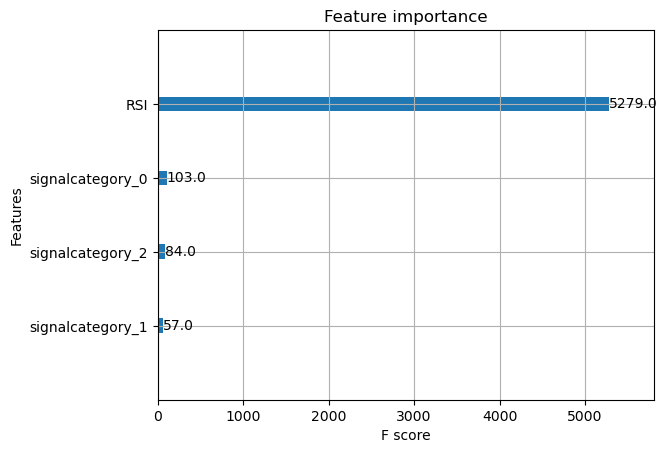

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


In [70]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)

In [71]:
from sklearn.neural_network import MLPClassifier

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

NN = MLPClassifier(hidden_layer_sizes=(50, 50, 60, 30, 9), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("="*20)

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test)) 

****Train Results****
Accuracy: 67.1522%
****Test Results****
Accuracy: 58.4926%


In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

[[1844    0    0]
 [ 430    0    0]
 [ 472    0    0]]
[[1071    0    0]
 [ 313    0    0]
 [ 447    0    0]]
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80      1844
         1.0       0.00      0.00      0.00       430
         2.0       0.00      0.00      0.00       472

    accuracy                           0.67      2746
   macro avg       0.22      0.33      0.27      2746
weighted avg       0.45      0.67      0.54      2746

              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74      1071
         1.0       0.00      0.00      0.00       313
         2.0       0.00      0.00      0.00       447

    accuracy                           0.58      1831
   macro avg       0.19      0.33      0.25      1831
weighted avg       0.34      0.58      0.43      1831



c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metr